Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long

C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

ROC AUC Score: 0.5314086754566256
Accuracy: 0.9961401355721147


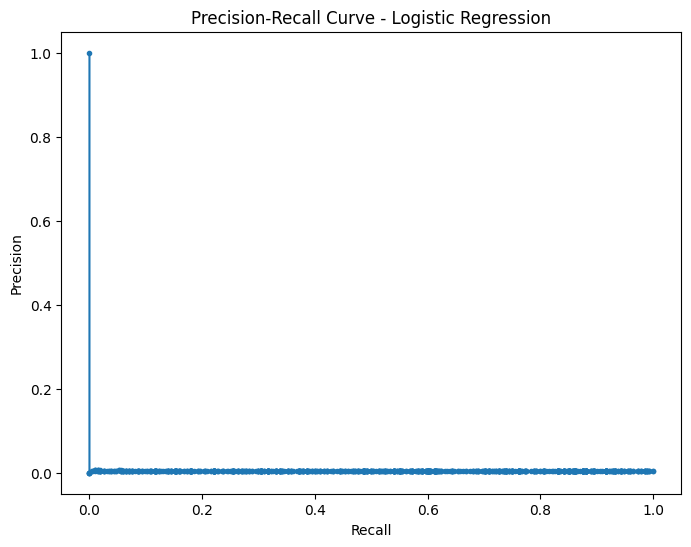


Evaluating Decision Tree:
Confusion Matrix:
[[536534  17040]
 [   176   1969]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    553574
           1       0.10      0.92      0.19      2145

    accuracy                           0.97    555719
   macro avg       0.55      0.94      0.59    555719
weighted avg       1.00      0.97      0.98    555719

ROC AUC Score: 0.9770773589645141
Accuracy: 0.9690203142235554


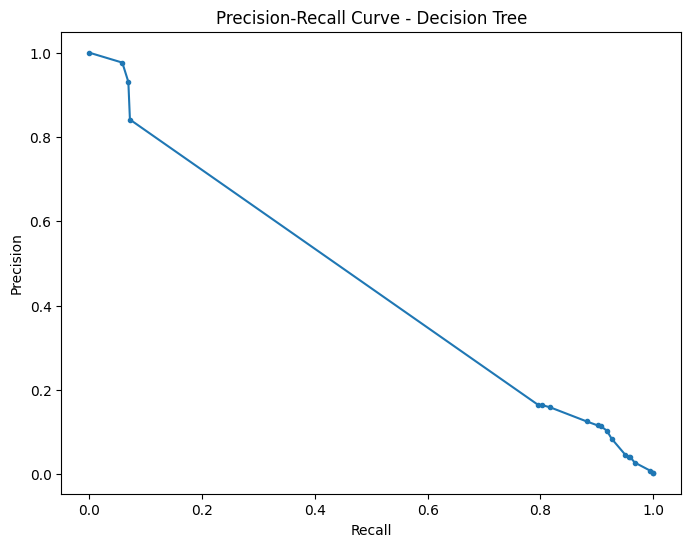

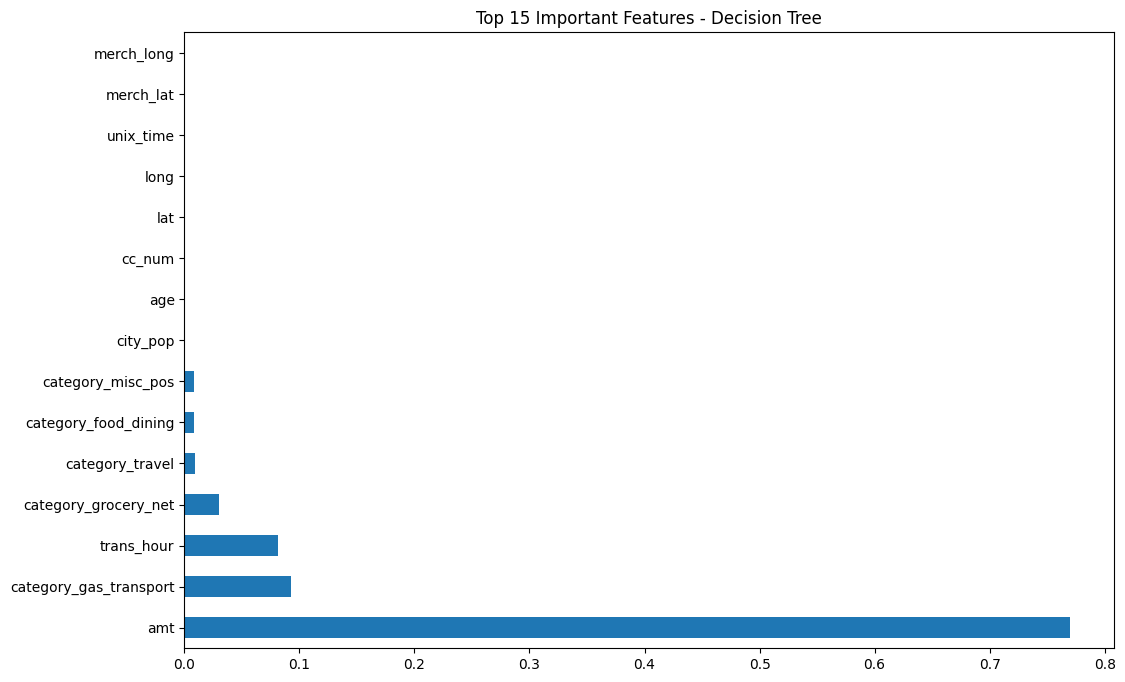


Evaluating Random Forest:
Confusion Matrix:
[[544878   8696]
 [   166   1979]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.19      0.92      0.31      2145

    accuracy                           0.98    555719
   macro avg       0.59      0.95      0.65    555719
weighted avg       1.00      0.98      0.99    555719

ROC AUC Score: 0.9910035876804548
Accuracy: 0.9840530915804571


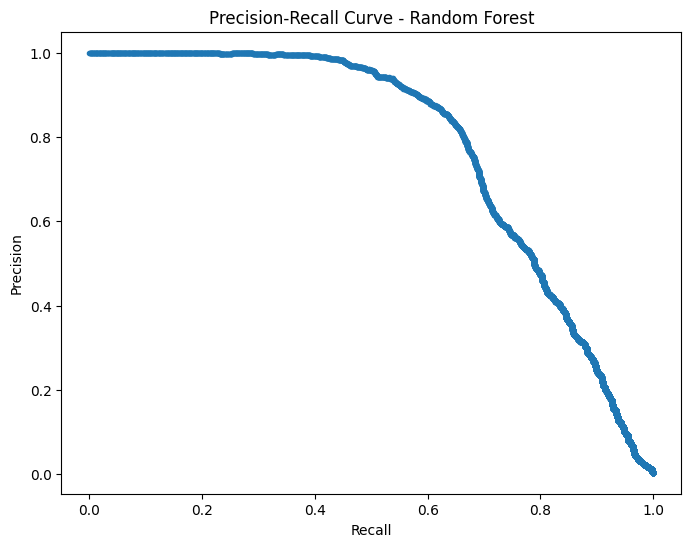

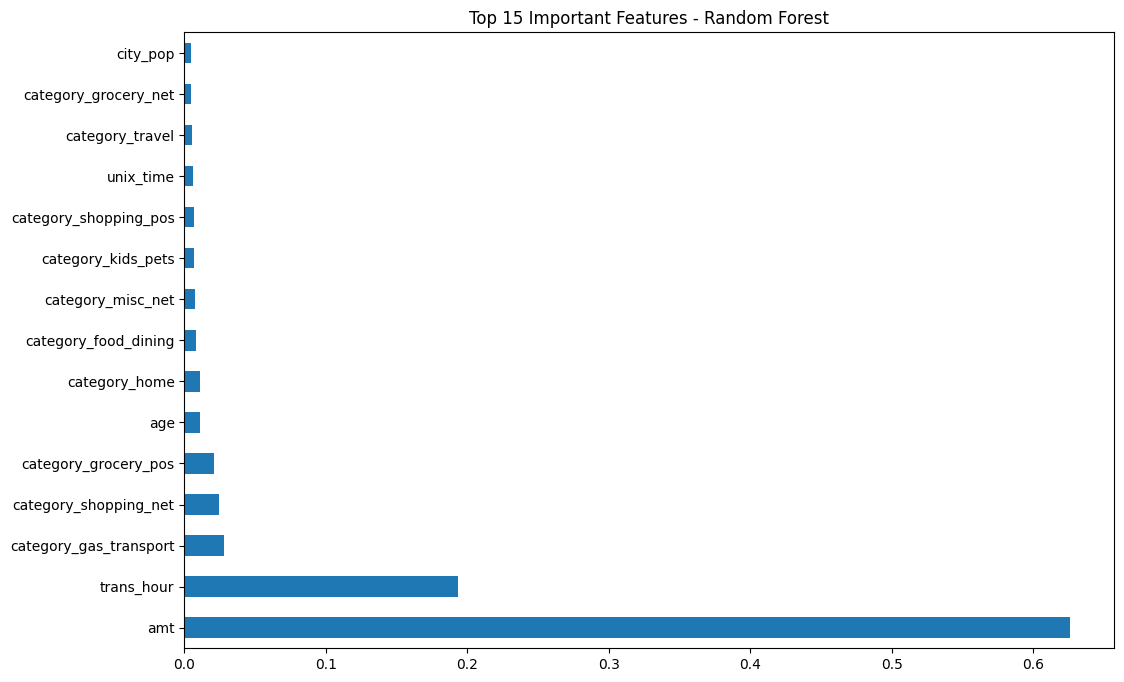


Evaluating Random Forest with SMOTE:
Confusion Matrix:
[[541104  12470]
 [   405   1740]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.12      0.81      0.21      2145

    accuracy                           0.98    555719
   macro avg       0.56      0.89      0.60    555719
weighted avg       1.00      0.98      0.99    555719

ROC AUC Score: 0.9756993236482883
Accuracy: 0.9768318160797094


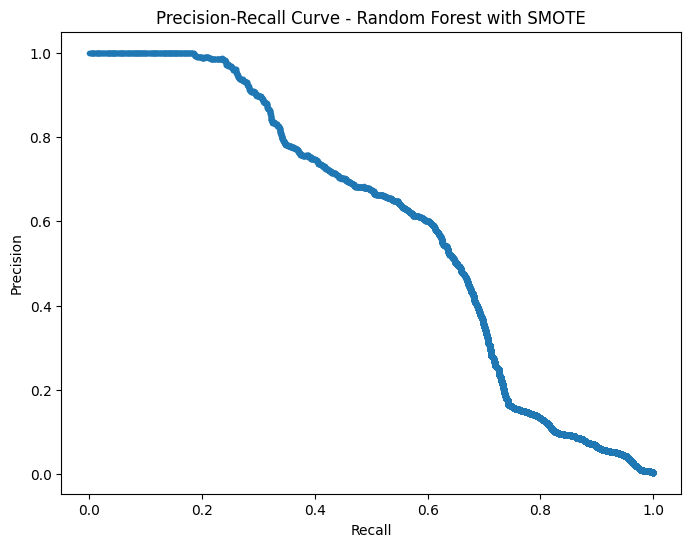

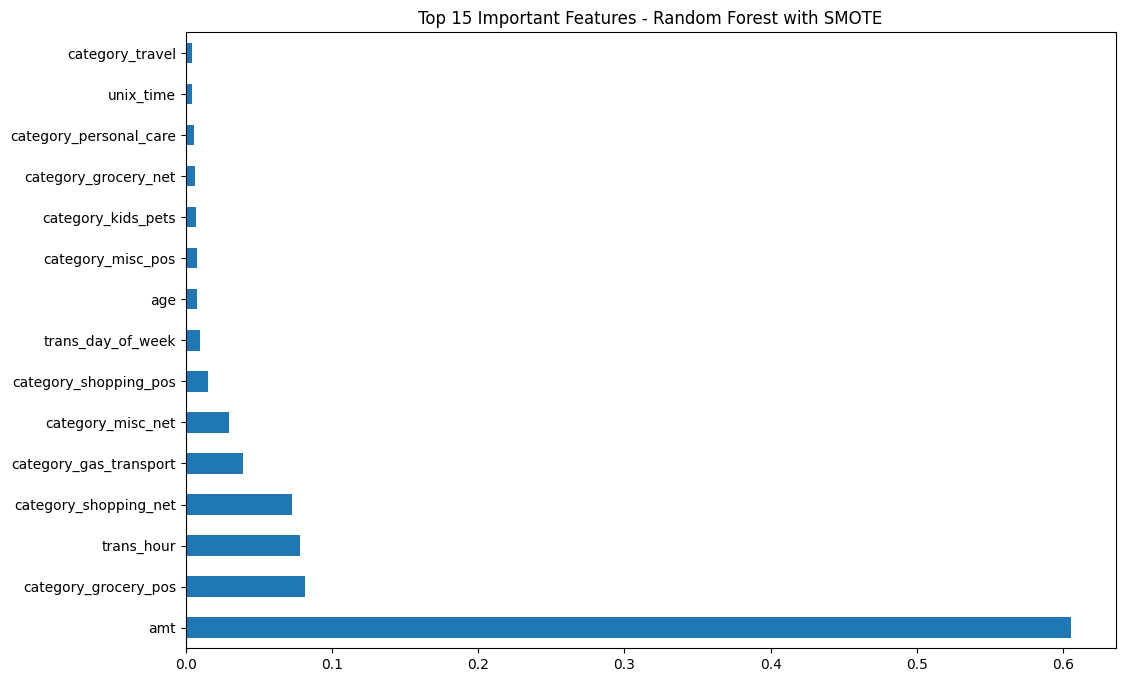


Model training complete. Best model saved as 'best_fraud_detection_model.pkl'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                            accuracy_score, roc_auc_score, precision_recall_curve)
from imblearn.over_sampling import SMOTE
import joblib

np.random.seed(42)

train_df = pd.read_csv('fraudTrain.csv')
test_df = pd.read_csv('fraudTest.csv')

print("Dataset Info:")
print(train_df.info())
print("\nClass Distribution:")
print(train_df['is_fraud'].value_counts(normalize=True))

def preprocess_data(df):
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['trans_hour'] = df['trans_date_trans_time'].dt.hour
    df['trans_day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
    df['trans_month'] = df['trans_date_trans_time'].dt.month
    
    df['dob'] = pd.to_datetime(df['dob'])
    df['age'] = (pd.to_datetime('today') - df['dob']).dt.days // 365

    df.drop(['Unnamed: 0', 'trans_date_trans_time', 'merchant', 'first', 'last', 
             'street', 'city', 'state', 'zip', 'dob', 'trans_num', 'job'], 
            axis=1, inplace=True)
    
    df = pd.get_dummies(df, columns=['category', 'gender'], drop_first=True)
    
    return df

train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)

X_train = train_df.drop('is_fraud', axis=1)
y_train = train_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)
y_test = test_df['is_fraud']

scaler = StandardScaler()
num_cols = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 
            'age', 'trans_hour', 'trans_day_of_week', 'trans_month']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Model Evaluation Function
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test, use_smote=False):
    print(f"\nEvaluating {model_name}:")
    
    if use_smote:
        smote = SMOTE(random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    else:
        X_train_res, y_train_res = X_train, y_train
    
    # Train the model
    model.fit(X_train_res, y_train_res)
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    
    # Plot precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.show()
    
    # Plot feature importance if available
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(12,8))
        feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
        feat_importances.nlargest(15).plot(kind='barh')
        plt.title(f'Top 15 Important Features - {model_name}')
        plt.show()
    
    return model

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, 
                                          class_weight='balanced', random_state=42, n_jobs=-1),
    'Random Forest with SMOTE': RandomForestClassifier(n_estimators=100, max_depth=10, 
                                                     random_state=42, n_jobs=-1)
}

# Train and evaluate models
trained_models = {}
for name, model in models.items():
    trained_models[name] = evaluate_model(
        model, 
        name, 
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        use_smote='SMOTE' in name
    )

# Save the best performing model (Random Forest with SMOTE in this case)
best_model = trained_models['Random Forest with SMOTE']
joblib.dump(best_model, 'best_fraud_detection_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("\nModel training complete. Best model saved as 'best_fraud_detection_model.pkl'")